# CS 180 - Machine Problem
project by: Gerizim M Villarante - 201802395

# Introduction

This project is an image classification problem.

It aims to classify images of a face to the following:
- face *with* a mask 
- face *without* a mask
- face with *incorrectly* worn mask

by using convolutional neural nets.

It is a relevant problem during this Covid-19 pandemic while being a good starter project in machine learning.

In the future, a better approach would be object detection because in image classification, the image classifier will be classifying the image based on features of the **whole** photo. This means that we need to feed only the face for the image classifier to work. But in object detection, we could feed a busy image and let the neural net define the bounding boxes and label them.

However, object detection is far more complex than image classification. Thus, image classification is used in this case.

# Methodology

## Dataset
![dataset banner](dataset_banner.png)

The [dataset](https://www.kaggle.com/andrewmvd/face-mask-detection) is published in [kaggle](https://www.kaggle.com/) by [Larxel](https://www.kaggle.com/andrewmvd).

> SOURCE: https://www.kaggle.com/andrewmvd/face-mask-detection

> LICENSE: [CC0: Public Domain](https://creativecommons.org/publicdomain/zero/1.0/)

It has 853 images with each image containing multiple faces that belong to 3 classes.
- with mask
- without mask
- mask worn incorrectly

The images (png format), containing multiple faces, have annotations provided in a separate xml file. The annotations contain the bounding box of the face and the class.

Because this project is an image classification problem and not object detection, the images need to be preprocessed by zooming on to each face and extracting the class to be fed to the model. This will result to more than the initial 853 images as each image contains multiple faces.

The preprocessed dataset will be divided into train, test, and validation sets.

### Dataset augmentation
To avoid overfitting, data augmentation is done to the preprocessed dataset. This is done by applying subtle random transformations to the images before feeding them to the neural network.

### Annotation format
Observe the annotation format below taken from `maksssksksss0.xml`.
```xml
<annotation>
    ...
    <object>
        <name>without_mask</name>
        ...
        <bndbox>
            <xmin>79</xmin>
            <ymin>105</ymin>
            <xmax>109</xmax>
            <ymax>142</ymax>
        </bndbox>
    </object>
    <object>
    ...
    </object>
    ...
</annotation>
```
Each face is denoted by an `<object>` tag with the class in the `<name>` tag and the bounding box in the `<bndbox>` tag. This will be important later when preprocessing the dataset.

## Model and its layers
The neural net will be composed of the following layers:

Layer | Description
:--- | :---
Convolution | learns filters to extract features from the image
Pooling | reduces the image size to help extract the important parts of the image
Dropout | relays the input to the output while dropping a percentage of data from the input to 0, this helps avoid overfitting by making the neural net to not overly depend to specific inputs
Flatten | flattens out an image to be able to interface with a dense layer
Dense | a fully connected layer

![cnn layers](layers.jpeg)

## Model training
- The preprocessed dataset will be fed to the model for multiple epochs. Each epoch is a complete iteration over all the data.
- The dataset is augmented randomly for *each* epoch. In essence, there will be a completely new random state for each epoch.

# Data and analysis
import required libraries and define constants

In [1]:
import itertools
import collections
import glob
import os
import pickle
import cv2
import tensorflow as tf
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from tensorflow.keras import layers
from lxml import etree

dataset_path = 'dataset'
model_path = 'model'
model_max_val_acc_path = 'model_max_val_acc'
model_min_val_loss_path = 'model_min_val_loss'
history_path = 'history'
batch_size = 32
epochs = 60
img_width, img_height = 256, 256
min_sub_image_size = 20

class_names = ['with_mask', 'mask_weared_incorrect', 'without_mask']
num_classes = len(class_names)
get_class_name_num = lambda x : {name: i for i, name in enumerate(class_names)}.get(x)

## Helper function to get a section from an image given a bounding box

In [2]:
def crop_to_bounding_box(image, box: '(ymin, ymax, xmin, xmax)', scale=1):
    ymin, ymax, xmin, xmax = box
    h, w = ymax - ymin, xmax - xmin
    x_center, y_center = (xmin + xmax) // 2, (ymin + ymax) // 2
    r = int(scale * (max(h, w) // 2))

    xmin, xmax = x_center - r, x_center + r
    ymin, ymax = y_center - r, y_center + r

    # bounds check
    maxh, maxw = image.shape[:2]
    xmin, ymin = max(0, xmin), max(0, ymin)
    xmax, ymax = min(maxw - 1, xmax), min(maxh - 1, ymax)

    return image[ymin:ymax, xmin:xmax]

## Dataset building and preprocessing
Associate each png image and xml annotation by zipping them. Observe that the paths of each pair of png image and xml annotation are correct.

In [3]:
def get_dataset_paths():
    image_paths = glob.glob(os.path.join(dataset_path, 'images', '*.png'))
    annotation_paths = [image_path.replace('images', 'annotations').replace('.png', '.xml') for image_path in image_paths]
    return zip(image_paths, annotation_paths)

list(get_dataset_paths())[:5]

[('dataset\\images\\maksssksksss0.png',
  'dataset\\annotations\\maksssksksss0.xml'),
 ('dataset\\images\\maksssksksss1.png',
  'dataset\\annotations\\maksssksksss1.xml'),
 ('dataset\\images\\maksssksksss10.png',
  'dataset\\annotations\\maksssksksss10.xml'),
 ('dataset\\images\\maksssksksss100.png',
  'dataset\\annotations\\maksssksksss100.xml'),
 ('dataset\\images\\maksssksksss101.png',
  'dataset\\annotations\\maksssksksss101.xml')]

Define a dataset generator. Each image with its annotation are opened and parsed to produce cropped images of the face as defined in the annotation.

In [4]:
def dataset_generator():
    dataset_paths = get_dataset_paths()

    images, labels = [], []
    for image_path, annotation_path in dataset_paths:
        # read the pair of image and its annotation
        image = cv2.imread(image_path)
        annotation = etree.parse(annotation_path).getroot()

        # for reach object (a face) in the annotation
        for obj in annotation.iterfind('object'):
            # read its label and bounding box
            label = get_class_name_num(obj.find('name').text)
            bounding_box = obj.find('bndbox')

            # get the region of interest from the image
            xmin = int(bounding_box.find('xmin').text)
            xmax = int(bounding_box.find('xmax').text)
            ymin = int(bounding_box.find('ymin').text)
            ymax = int(bounding_box.find('ymax').text)

            image_section = crop_to_bounding_box(image, (ymin, ymax, xmin, xmax), scale=1.5)

            # skip cropped image if too small
            h, w = image_section.shape[:2]
            if min(h, w) < min_sub_image_size: continue

            image_section = tf.image.resize_with_pad(image_section, img_height, img_width)
            yield (image_section, label)

# create a TensorFlow Dataset object from the generator for an optimized input pipeline
dataset = tf.data.Dataset.from_generator(
    dataset_generator,
    output_signature=(
        tf.TensorSpec(shape=(img_height, img_width, 3), dtype=tf.uint8),
        tf.TensorSpec(shape=(), dtype=tf.uint8)
    )
).shuffle(1024, seed=1015).cache().prefetch(buffer_size=tf.data.AUTOTUNE)

Peek at the dataset to check if the dataset is working as expected.

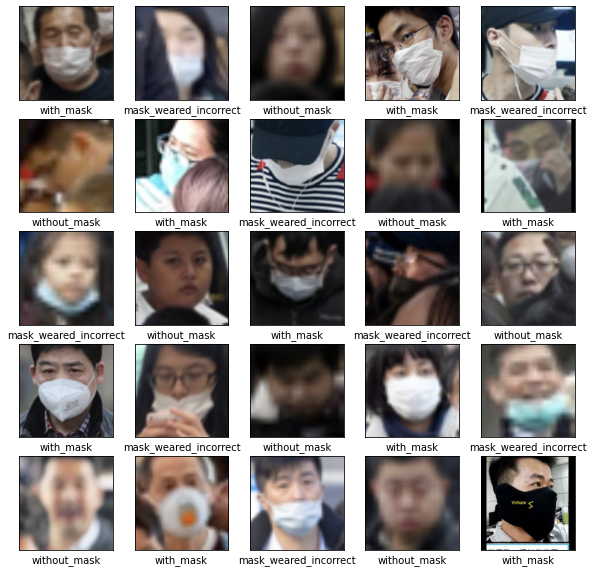

In [5]:
plt.figure(figsize=(10,10))
total = 0
for image, label in dataset.as_numpy_iterator():
    if label != total % 3: continue
    if total >= 25: break
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    plt.subplot(5, 5, total + 1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(image)
    plt.xlabel(class_names[label])
    total += 1
plt.show()

## Dataset Analysis
The dataset is admittedly unbalanced with an abundance in faces with mask (2734) and a small set for faces with incorrectly worn mask (112). But we'll work with it and the model should still be able to fit it.

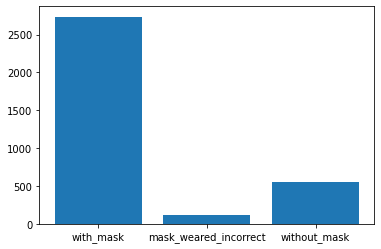

array([2734,  112,  550], dtype=int64)

In [6]:
def plot_dataset_histogram():
    labels = np.fromiter(dataset.map(lambda img, label: label, num_parallel_calls=tf.data.AUTOTUNE, deterministic=False).as_numpy_iterator(), dtype='uint8')
    class_name_idx, counts = np.unique(labels, return_counts=True)
    names = np.vectorize(lambda idx: class_names[idx])(class_name_idx)
    plt.bar(names, counts)
    plt.show()
    return counts

plot_dataset_histogram()

Split the dataset into a training set and validation set with a 80:20 split. Test sets are automatically done by the model.
Batch the datasets for quicker model training. Use cache and prefetch for faster data retrieval.

In [7]:
def is_val(x, y):
    return x % 5 == 0

def is_train(x, y):
    return not is_val(x, y)

recover = lambda x, y: y

train_ds = dataset.enumerate().filter(is_train).map(recover)
val_ds = dataset.enumerate().filter(is_val).map(recover)

train_ds = train_ds.batch(batch_size)
train_ds = train_ds.shuffle(32, seed=47).cache().prefetch(buffer_size=tf.data.AUTOTUNE)

val_ds = val_ds.batch(batch_size)
val_ds = val_ds.shuffle(32, seed=47).cache().prefetch(buffer_size=tf.data.AUTOTUNE)

## Dataset augmentation
Data augmentation is done to prevent overfitting. We can apply a random horizontal flip, random rotation in the range of $\left[ -2\pi \times 0.05, 2\pi \times 0.05 \right]$, and random translation on the y-axis. The following is a demonstration on how it works.

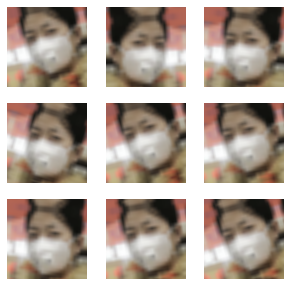

In [8]:
data_augmentation = tf.keras.Sequential([
    layers.experimental.preprocessing.RandomFlip("horizontal", input_shape=(img_height, img_width, 3)),
    layers.experimental.preprocessing.RandomTranslation((0, 0.15), 0),
    layers.experimental.preprocessing.RandomRotation(0.05),
])

plt.figure(figsize=(5, 5))
for image, _ in dataset:
    image = tf.expand_dims(image, 0)
    for i in range(9):
        augmented_image = data_augmentation(image)[0]
        augmented_image = augmented_image.numpy().astype('uint8')
        augmented_image = cv2.cvtColor(augmented_image, cv2.COLOR_BGR2RGB)
        plt.subplot(3, 3, i + 1)
        plt.imshow(augmented_image)
        plt.axis("off")
    break

## Model
Data augmentation is attached at the start. It is only active during `model.fit` but not during `model.predict` and `model.evaluate`

Use a combination of convolution, pooling, dropout, and dense layers.

The following explains each layer:
```python
layers.Conv2D(filters, kernel_size)
layers.MaxPool2D(kernel_size)       # reduces the image size by getting the max value in a kernel_size
layers.Dropout(rate)                # sets input units to 0 with a frequency of rate
layers.Flatten()
layers.Dense(units)                 # a fully connected dense layer
```

In [9]:
model = tf.keras.Sequential([
    data_augmentation,
    layers.experimental.preprocessing.Rescaling(1./255),
    layers.Conv2D(16, (3, 3), activation='relu'),
    layers.MaxPool2D((2, 2)),
    layers.Dropout(0.2),
    layers.Conv2D(32, (3, 3), activation='relu'),
    layers.MaxPool2D((2, 2)),
    layers.Dropout(0.2),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPool2D((2, 2)),
    layers.Dropout(0.2),
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dense(num_classes)
])

Adam optimizer is used as multiple sources indicate that it is one of the best ones for a convolutional neural network.

We use the categorical crossentropy because we are categorizing more than two classes (3). We use sparse because the labels are single integers `[0, 1, 2]` instead of being one-hot encoded `[[1, 0, 0], [0, 1, 0], [0, 0, 1]]`. The `from_logits` parameter is set to `True` because the last layer has an activation of `relu` instead of `softmax`.

In [10]:
model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['accuracy']
)

model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
sequential (Sequential)      (None, 256, 256, 3)       0         
_________________________________________________________________
rescaling (Rescaling)        (None, 256, 256, 3)       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 254, 254, 16)      448       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 127, 127, 16)      0         
_________________________________________________________________
dropout (Dropout)            (None, 127, 127, 16)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 125, 125, 32)      4640      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 62, 62, 32)       

## Model fitting
Start fitting the model and save the history log to a variable to be graphed later. GPU support is recommended. Reduce number of epochs if needed.

In [11]:
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  1


Save the best model in terms of maximum validation accuracy and minimum validation loss. This allows us to save the model just before it overfits the training dataset.

In [12]:
save_max_val_acc = tf.keras.callbacks.ModelCheckpoint(
    filepath=model_max_val_acc_path,
    monitor='val_accuracy',
    mode='max',
    save_best_only=True
)

save_min_val_loss = tf.keras.callbacks.ModelCheckpoint(
    filepath=model_min_val_loss_path,
    monitor='val_loss',
    mode='min',
    save_best_only=True
)

history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=epochs,
    callbacks=[save_max_val_acc, save_min_val_loss]
)

Epoch 1/60
85/85 [==============================] - 32s 146ms/step - loss: 0.5099 - accuracy: 0.8579 - val_loss: 0.2555 - val_accuracy: 0.9250
INFO:tensorflow:Assets written to: model_max_val_acc\assets
INFO:tensorflow:Assets written to: model_min_val_loss\assets
Epoch 2/60
85/85 [==============================] - 3s 40ms/step - loss: 0.2509 - accuracy: 0.9256 - val_loss: 0.2515 - val_accuracy: 0.9309
INFO:tensorflow:Assets written to: model_max_val_acc\assets
INFO:tensorflow:Assets written to: model_min_val_loss\assets
Epoch 3/60
85/85 [==============================] - 3s 41ms/step - loss: 0.2408 - accuracy: 0.9286 - val_loss: 0.2390 - val_accuracy: 0.9309
INFO:tensorflow:Assets written to: model_min_val_loss\assets
Epoch 4/60
85/85 [==============================] - 3s 40ms/step - loss: 0.2334 - accuracy: 0.9297 - val_loss: 0.2350 - val_accuracy: 0.9324
INFO:tensorflow:Assets written to: model_max_val_acc\assets
INFO:tensorflow:Assets written to: model_min_val_loss\assets
Epoch 5/60

Save the complete model and history too.

In [13]:
model.save(model_path)
with open(history_path, 'wb') as f:
    pickle.dump(history.history, f)

INFO:tensorflow:Assets written to: model\assets


---
We now have the:
- final model
- maximum validation accuracy checkpoint model
- minimum validation loss checkpoint model

The next sections aim to compare the three.

---

## Accuracy and loss graphs
From here, we can check through the graph if the model is overfitting or underfitting.

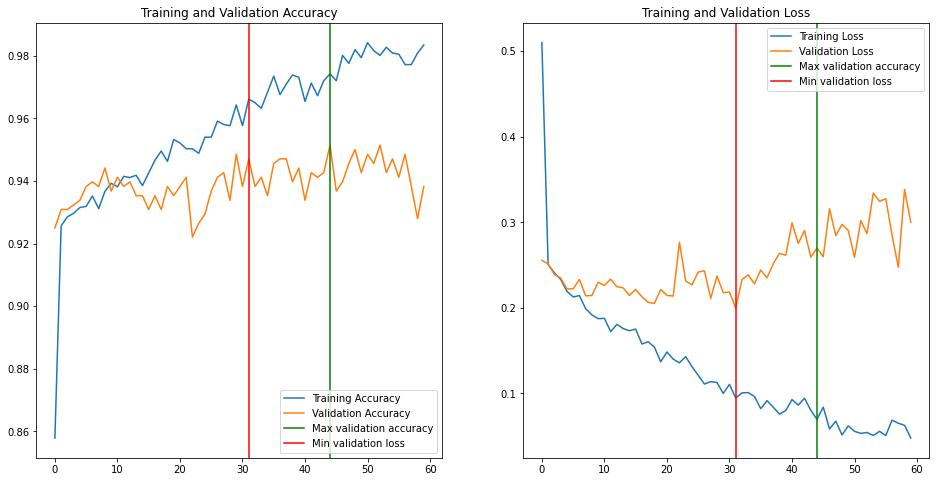

In [52]:
with open(history_path, 'rb') as f:
    history = pickle.load(f)

acc = history['accuracy']
val_acc = history['val_accuracy']

loss = history['loss']
val_loss = history['val_loss']

plt.figure(figsize=(16, 8))
plt.subplot(1, 2, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.axvline(np.argmax(val_acc), label='Max validation accuracy', c='g')
plt.axvline(np.argmin(val_loss), label='Min validation loss', c='r')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.axvline(np.argmax(val_acc), label='Max validation accuracy', c='g')
plt.axvline(np.argmin(val_loss), label='Min validation loss', c='r')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

Looking at the accuracy graph, it does not indicate any overfitting. Although at the loss graph, it seems that the model started overfitting after it achieved the minimum validation loss. Still, in this case we are more concerned about the accuracy. Thus, both the final model and max validation checkpoint are good candidates.

## Confusion matrix
Plotting the confusion matrix in each checkpoint, we get the following:

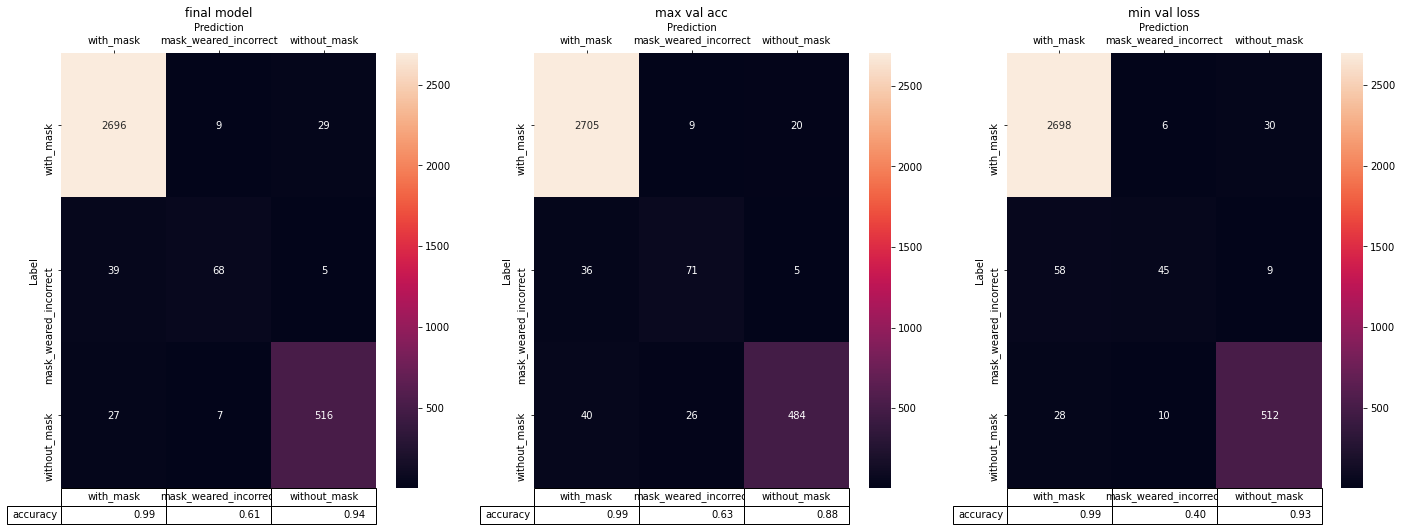

In [80]:
def get_confusion_matrix(path):
    model = tf.keras.models.load_model(path)

    y_pred = []
    y_true = []

    # iterate over the dataset
    for image_batch, label_batch in itertools.chain(train_ds, val_ds):
        # append true labels
        y_true.append(label_batch)
        # compute predictions
        preds = model.predict(image_batch)
        # append predicted labels
        y_pred.append(np.argmax(preds, axis=-1))

    # convert the true and predicted labels into tensors
    labels_idx = tf.concat([item for item in y_true], axis=0)
    predictions = tf.concat([item for item in y_pred], axis=0)

    return tf.math.confusion_matrix(labels_idx, predictions, num_classes=num_classes)

def plot_cm_acc(ax, path, title=None):
    cm = get_confusion_matrix(path).numpy()
    accuracies = cm.diagonal() / cm.sum(axis=1)
    accuracies = ['{:.2f}'.format(x) for x in accuracies]

    sns.heatmap(cm, xticklabels=class_names, yticklabels=class_names, annot=True, fmt='g')
    plt.xlabel('Prediction')
    plt.ylabel('Label')
    table = plt.table(
        cellText=[accuracies],
        rowLabels=['accuracy'],
        colLabels=class_names,
        loc='bottom'
    )
    table.auto_set_font_size(False)
    table.set_fontsize(10)
    table.scale(1, 1.5)
    ax.set_title(title)
    ax.xaxis.set_ticks_position('top')
    ax.xaxis.set_label_position('top')

plt.figure(figsize=(24, 8))

plot_cm_acc(plt.subplot(1, 3, 1), model_path, title='final model')
plot_cm_acc(plt.subplot(1, 3, 2), model_max_val_acc_path, title='max val acc')
plot_cm_acc(plt.subplot(1, 3, 3), model_min_val_loss_path, title='min val loss')

plt.show()

Observe that the min val loss checkpoint cannot classify the mask_weared_incorrect accurately compared to the other two. Thus, it just confirms that either the final model or the max val accuracy checkpoint are desirable. Also, the mask_weared_incorrect accuracy is low accross the board. This can be explained by the lack of dataset for that class.

Now we can check the accuracy of the three models against the whole dataset.

In [54]:
def evaluate_model(path):
    model = tf.keras.models.load_model(path)
    loss, acc = model.evaluate(dataset.batch(batch_size), verbose=2)
    print("{}, accuracy: {:5.2f}%".format(path, 100 * acc))

evaluate_model(model_path)
evaluate_model(model_max_val_acc_path)
evaluate_model(model_min_val_loss_path)

107/107 - 1s - loss: 0.1183 - accuracy: 0.9658
model, accuracy: 96.58%
107/107 - 1s - loss: 0.1373 - accuracy: 0.9600
model_max_val_acc, accuracy: 96.00%
107/107 - 2s - loss: 0.1281 - accuracy: 0.9585
model_min_val_loss, accuracy: 95.85%


# Conclusion
To conclude, these accuracies show that the model works well in classifying faces. However, the unbalanced dataset had a great effect to the accuracy for the mask_weared_incorrectly class. Still, with the help of data augmentation, we were able to work with it.

The best model to use depends on preference
- for better classification of the without_mask class, the max validation accuracy model is better
- for better classification of the mask_weared_incorrectly class, the final model is better

## Live use demonstration
For fun, we could try to use it live using the webcam with the help of a face detection neural network that's well known and provided by Aleksandr Rybnikov. When a face is detected, we can crop it out and feed it to the model live. The following is the demonstration. It works best in flat and well-lit lighting conditions.

---
**You could run the cell below without running the other cells.**

---

In [3]:
import cv2
import tensorflow as tf

model_path = 'model'
model_max_val_acc_path = 'model_max_val_acc'
model_min_val_loss_path = 'model_min_val_loss'

def crop_to_bounding_box(image, box: '(ymin, ymax, xmin, xmax)', scale=1):
    ymin, ymax, xmin, xmax = box
    h, w = ymax - ymin, xmax - xmin
    x_center, y_center = (xmin + xmax) // 2, (ymin + ymax) // 2
    r = int(scale * (max(h, w) // 2))

    xmin, xmax = x_center - r, x_center + r
    ymin, ymax = y_center - r, y_center + r

    # bounds check
    maxh, maxw = image.shape[:2]
    xmin, ymin = max(0, xmin), max(0, ymin)
    xmax, ymax = min(maxw - 1, xmax), min(maxh - 1, ymax)

    return image[ymin:ymax, xmin:xmax]

# model = tf.keras.models.load_model(model_path)
model = tf.keras.models.load_model(model_max_val_acc_path)

video = cv2.VideoCapture(0)
video_h, video_w = video.read()[1].shape[:2]
colors = [(0, 255, 0), (255, 0, 0), (0, 0, 255)]

prototxtPath = 'face_detector\\deploy.prototxt'
weightsPath = 'face_detector\\res10_300x300_ssd_iter_140000.caffemodel'
faceNet = cv2.dnn.readNet(prototxtPath, weightsPath)

while(True):
    ret, frame = video.read()
    frame = cv2.flip(frame, 1)

    blob = cv2.dnn.blobFromImage(frame, 1.0, (224, 224), (104.0, 177.0, 123.0))

    # pass the blob through the network and obtain the face detections
    faceNet.setInput(blob)
    detections = faceNet.forward()

    faces_bounds = []

    # loop over the detections
    for i in range(detections.shape[2]):
        # extract confidence
        confidence = detections[0, 0, i, 2]

        # filter out weak detections
        if confidence > 0.5:
            box = detections[0, 0, i, 3:7] * np.array([video_w, video_h, video_w, video_h])
            xmin, ymin, xmax, ymax = box.astype("int")

            xmin, ymin = max(0, xmin), max(0, ymin)
            xmax, ymax = min(video_w - 1, xmax), min(video_h - 1, ymax)

            faces_bounds.append((ymin, ymax, xmin, xmax))

    # pass the cropped image to our model
    if len(faces_bounds):
        preds = model.predict(
            np.array([
                tf.image.resize_with_pad(
                    crop_to_bounding_box(frame, bounds, scale=1.5), 
                    img_height,
                    img_width
                ) for bounds in faces_bounds],
                dtype='uint8'
            )
        )

        # for x in [tf.image.resize_with_pad(crop_to_bounding_box(frame, bounds, scale=1.5), img_height, img_width) for bounds in faces_bounds]:
        #     cv2.imshow('image', x.numpy().astype('uint8'))
        #     cv2.waitKey(0)

        # Draw the rectangle around each face
        for (ymin, ymax, xmin, xmax), pred in zip(faces_bounds, preds):
            score = tf.nn.softmax(pred)
            class_name_idx = np.argmax(score)
            class_name, confidence = class_names[class_name_idx], 100 * np.max(score)
            # print(class_name_idx, confidence, class_name)
            
            color = colors[class_name_idx]

            cv2.rectangle(frame, (xmin, ymin), (xmax, ymax), color, 2)
            cv2.putText(frame, f'{class_name} {confidence:.2f}', (xmin, ymin - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.45, color, 1)

    cv2.imshow('press q to quit', frame)
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break

video.release()
cv2.destroyAllWindows()